In [1]:
from sklearn.model_selection import train_test_split
from sklearn.datasets import fetch_lfw_people
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.metrics import f1_score

import matplotlib.pyplot as plt

In [2]:
lfw_people = fetch_lfw_people(min_faces_per_person=70, resize=0.4)

In [3]:
n_samples, h, w = lfw_people.images.shape
X = lfw_people.data
y = lfw_people.target
target_names = lfw_people.target_names
n_classes = target_names.shape[0]

In [4]:
def plot_gallery(images, titles, h, w, n_row=3, n_col=4):
    """Helper function to plot a gallery of portraits"""
    plt.figure(figsize=(1.8 * n_col, 2.4 * n_row))
    plt.subplots_adjust(bottom=0, left=0.01, right=0.99, top=0.90, hspace=0.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i].reshape((h, w)), cmap=plt.cm.gray)
        plt.title(titles[i], size=12)
        plt.xticks(())
        plt.yticks(())

In [5]:
lfw_people.images.shape

(1288, 50, 37)

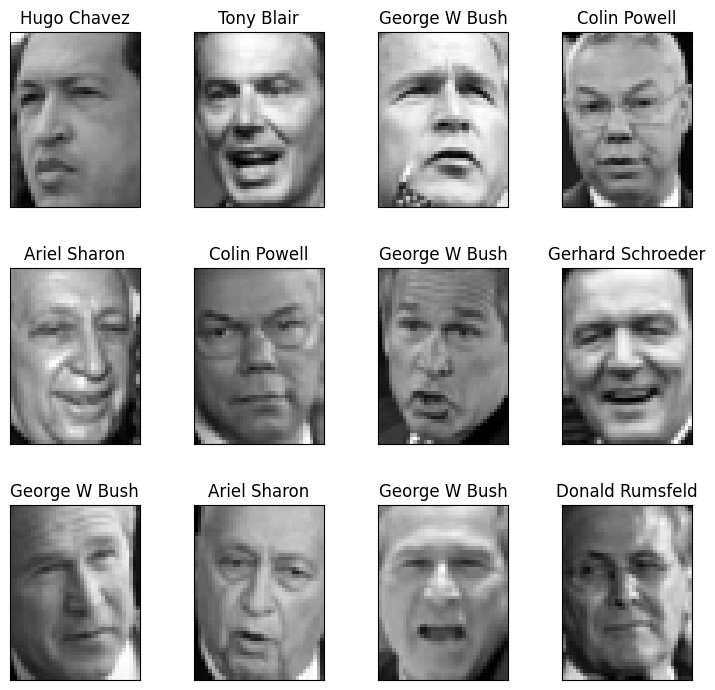

In [6]:
plot_n = 12
images = X[:plot_n]
titles = [target_names[i] for i in y[:plot_n]]
plot_gallery(images, titles, h, w)

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

### Aufgaben

- Erster Teil 
    - Führen Sie eine PCA der Daten 200 Dimensionen durch
    - Finden Sie dann mit Hilfe eines Grid Search auf die unten aufgeführten Parameter ein optimales Modell. Das Modell soll ein SVC mit `kernel=rbf` und `class_weight='balanced'` sein.
    - BONUS: Plotten Sie die ersten 16 Hauptkomponenten
```
param_grid = {
         'C': [1e3, 5e3, 1e4, 5e4, 1e5],
          'gamma': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1],
          }
```
- Zweiter Teil
    - Wie hängt der gewichtete F1 Score des besten Modells von der Anzahl der Dimensionen ab, auf die Sie projizieren? Führen mehr Dimensionen zu einer besseren Lösung?


In [18]:
pca = PCA(n_components=200)
X_200d = pca.fit_transform(X_train)

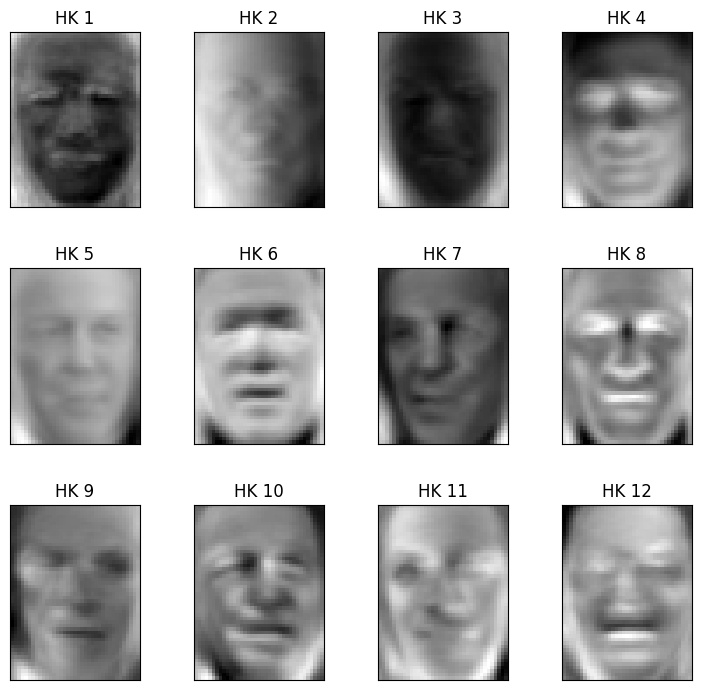

In [19]:
plot_gallery(pca.components_[:16], [f'HK {i+1}' for i in range(16)], h, w)

In [20]:
svc = SVC(kernel="rbf", class_weight="balanced")

param_grid = {
         'C': [1e3, 5e3, 1e4, 5e4, 1e5],
          'gamma': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1],
          }

In [21]:
clf = GridSearchCV(estimator=svc, param_grid=param_grid, scoring="f1_weighted")
clf.fit(X_200d, y_train)

GridSearchCV(estimator=SVC(class_weight='balanced'),
             param_grid={'C': [1000.0, 5000.0, 10000.0, 50000.0, 100000.0],
                         'gamma': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1]},
             scoring='f1_weighted')

In [22]:
print(f'Best parameters: {clf.best_params_}')
print(f'Best weighted F1 score: {clf.best_score_:.2f}')

Best parameters: {'C': 1000.0, 'gamma': 0.01}
Best weighted F1 score: 0.82


In [23]:
X_test_pca = pca.transform(X_test)
y_pred = clf.predict(X_test_pca)
test_f1_score = f1_score(y_test, y_pred, average='weighted')
print("F1 score on test data:", test_f1_score)

F1 score on test data: 0.8119422574610634


In [29]:
dimensions = list(range(50, 1000, 50))
f1_scores = []

In [30]:
for dim in dimensions:
    pca = PCA(n_components=dim)
    X_train_pca = pca.fit_transform(X_train)
    X_test_pca = pca.transform(X_test)
    clf = GridSearchCV(estimator=svc, param_grid=param_grid, scoring='f1_weighted')
    clf.fit(X_train_pca, y_train)
    y_pred = clf.predict(X_test_pca)
    f1_scores.append(f1_score(y_test, y_pred, average='weighted'))

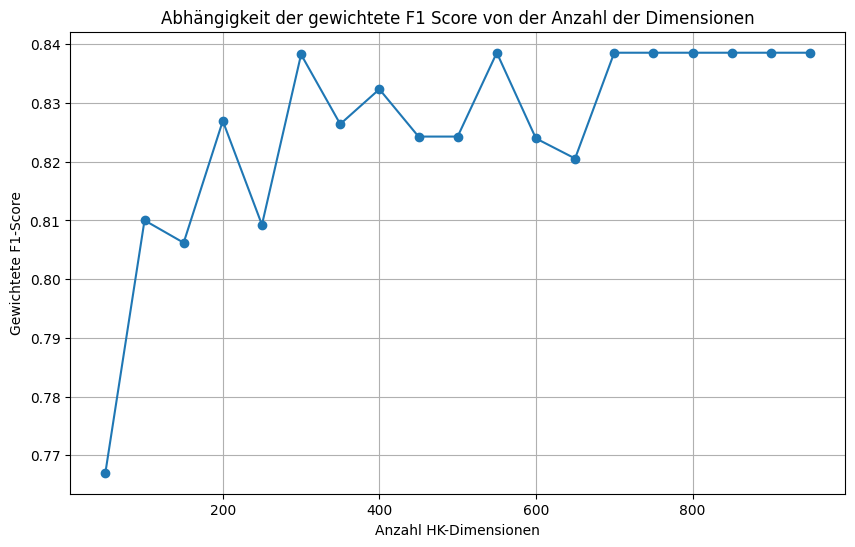

In [31]:
plt.figure(figsize=(10,6))
plt.plot(dimensions, f1_scores, marker='o')
plt.xlabel('Anzahl HK-Dimensionen')
plt.ylabel('Gewichtete F1-Score')
plt.title('Abhängigkeit der gewichtete F1 Score von der Anzahl der Dimensionen')
plt.grid(True)
plt.show()

Der Elbow Point liegt bei 300 Dimensionen. Dies ist die Anzahl der Dimensionen, bei der die Hinzufügung weiterer Dimensionen keine signifikanten Verbesserungen des F1-Scores mehr bringt.